In [1]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns, SuperTrend
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import get_n_columns

In [2]:
class SaEnvelope():
    def __init__(
        self,
        df,
        type=["long"],
        ma_base_window=3,
        envelopes=[0.05, 0.1, 0.15],
        src="close",
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.ma_base_window = ma_base_window
        self.envelopes = envelopes
        self.src = src

        
    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )
        
        # -- Populate indicators --    
        if self.src == "close":
            src = df["close"]
        elif self.src == "ohlc4":
            src = (df["close"] + df["high"] + df["low"] + df["open"]) / 4
        # src = df["close"]
        df['ma_base'] = ta.trend.sma_indicator(close=src, window=self.ma_base_window).shift(1)
        high_envelopes = [round(1/(1-e)-1, 3) for e in self.envelopes]
        # low_envelopes = [round(abs(1/(1+e)-1), 3) for e in self.envelopes]
        for i in range(1, len(self.envelopes) + 1):
            df[f'ma_high_{i}'] = df['ma_base'] * (1 + high_envelopes[i-1])
            df[f'ma_low_{i}'] = df['ma_base'] * (1 - self.envelopes[i-1])
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["close_long"] = False
        df["close_short"] = False

        for i in range(1, len(self.envelopes) + 1):
            df[f"open_short_{i}"] = False
            df[f"open_long_{i}"] = False
        
        if self.use_long:
            # -- Populate open long--
            for i in range(1, len(self.envelopes) + 1):
                df.loc[
                    (df['low'] <= df[f'ma_low_{i}'])
                    , f"open_long_{i}"
                ] = True
            
            # -- Populate close long limit --
            df.loc[
                (df['high'] >= df['ma_base'])
                , "close_long"
            ] = True
            
        
        if self.use_short:
            # -- Populate open short limit --
            for i in range(1, len(self.envelopes) + 1):
                df.loc[
                    (df['high'] >= df[f'ma_high_{i}'])
                    , f"open_short_{i}"
                ] = True
            
            # -- Populate close short market --
            df.loc[
                (df['low'] <= df['ma_base'])
                , "close_short"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += current_position['size'] * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += current_position['size'] * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long']:
                        close_price = row['ma_base']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += current_position['size'] * trade_result
                        close_trade_size = current_position['size'] + (current_position['size'] * trade_result)
                        fee = close_trade_size * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Limit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": close_trade_size,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Limit --
                    if row['close_short']:
                        # if current_position['reason'] == "Limit Envelop 3":
                        #     print("ok")
                        close_price = row['ma_base']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        wallet += current_position['size'] * trade_result
                        close_trade_size = current_position['size'] + (current_position['size'] * trade_result)
                        fee = close_trade_size * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Limit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": close_trade_size,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                for i in range(1, len(self.envelopes) + 1):
                    # -- Open long Limit --
                    if row[f'open_long_{i}']:
                        if current_position and current_position["envelope"] >= i:
                            continue
                        open_price = row[f'ma_low_{i}']
                        fee = wallet * maker_fee * (1/len(self.envelopes)) * leverage
                        wallet -= fee
                        pos_size = wallet * (1/len(self.envelopes)) * leverage
                        if current_position:
                            current_position["price"] = (current_position["size"] * current_position["price"] + open_price * pos_size) / (current_position["size"] + pos_size)
                            current_position["size"] = current_position["size"] + pos_size
                            current_position["fee"] = current_position["fee"] + fee
                            current_position["envelope"] = i
                            current_position["reason"] = f"Limit Envelop {i}"
                        else:
                            current_position = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee":fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "LONG",
                                "envelope": i,
                            }
                    elif row[f'open_short_{i}']:
                        if current_position and current_position["envelope"] >= i:
                            continue
                        open_price = row[f'ma_high_{i}']
                        fee = wallet * maker_fee * (1/len(self.envelopes)) * leverage
                        wallet -= fee
                        pos_size = wallet * (1/len(self.envelopes)) * leverage
                        if current_position:
                            current_position["price"] = (current_position["size"] * current_position["price"] + open_price * pos_size) / (current_position["size"] + pos_size)
                            current_position["size"] = current_position["size"] + pos_size
                            current_position["fee"] = current_position["fee"] + fee
                            current_position["envelope"] = i
                            current_position["reason"] = f"Limit Envelop {i}"
                        else:
                            current_position = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee":fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "SHORT",
                                "envelope": i,
                            }
                    else:
                        break
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }      
        

In [3]:
exchange_name = "binance"
pair = "ETH/USDT"
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)
df

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...
2023-08-07 08:00:00,1836.87,1836.89,1833.31,1833.32,5619.19840
2023-08-07 09:00:00,1833.32,1836.13,1832.55,1835.63,3994.09660
2023-08-07 10:00:00,1835.64,1837.39,1833.50,1837.38,4040.73550


Period: [2017-08-17 00:00:00] -> [2023-08-07 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 31968.39 $
Performance vs US dollar: 3096.84 %
Sharpe Ratio: 2.78
Worst Drawdown T|D: -12.39% | -15.9%
Buy and hold performance: 506.74 %
Performance vs buy and hold: 426.89 %
Total trades on the period: 312
Global Win rate: 78.21 %
Average Profit: 2.26 %
Total fees paid 561.88$

Best trades: +9.84 % the 2020-03-13 03:00:00 -> 2020-03-13 04:00:00
Worst trades: -15.67 % the 2020-03-12 07:00:00 -> 2020-03-12 14:00:00


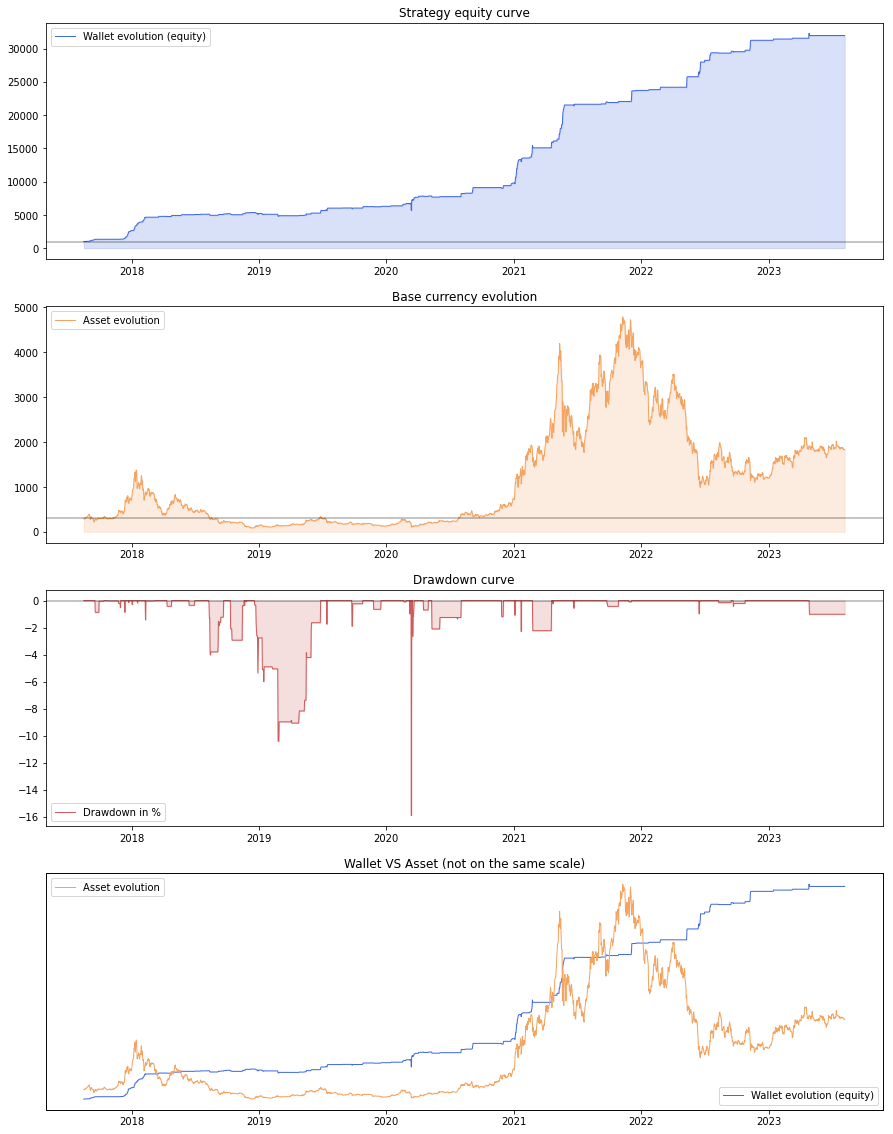

In [4]:
# strat = SaEnvelope( # BTC
#     df = df.loc[:],
#     type=["long", "short"],
#     ma_base_window=7,
#     envelopes=[0.07, 0.1],
#     src="close",
# )
strat = SaEnvelope( # ETH
    df = df.loc[:],
    type=["long", "short"],
    ma_base_window=5,
    envelopes=[0.07, 0.09, 0.12],
    src="close",
)
# strat = SaEnvelope( # ADA EGLD
#     df = df.loc[:],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.09, 0.12, 0.15],
#     src="close",
# )
# strat = SaEnvelope( # KSM OCEAN REN BAR
#     df = df.loc[:],
#     type=["long", "short"],
#     ma_base_window=5,
#     envelopes=[0.07, 0.1, 0.15, 0.2],
#     src="close",
# )


strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])

plot_wallet_vs_asset(df_days=df_days)


----- 2017 Cumulative Performances: 165.12% -----


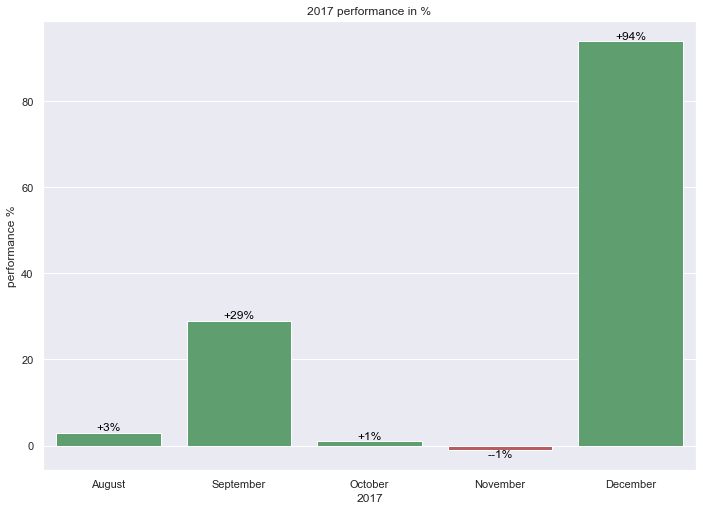

----- 2018 Cumulative Performances: 96.86% -----


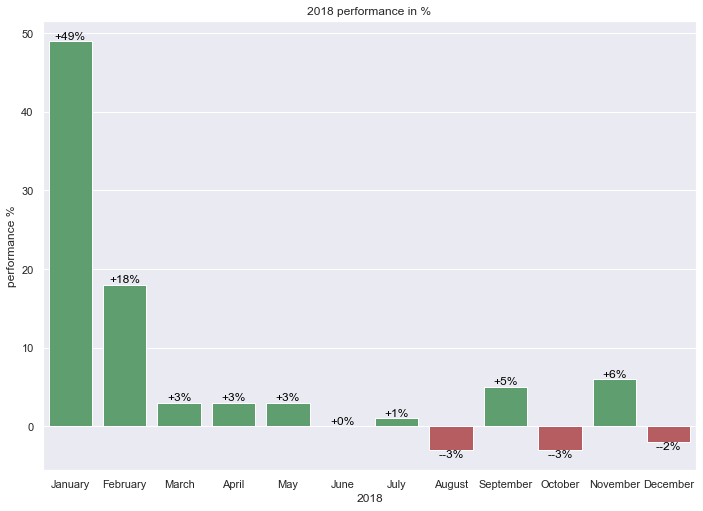

----- 2019 Cumulative Performances: 20.63% -----


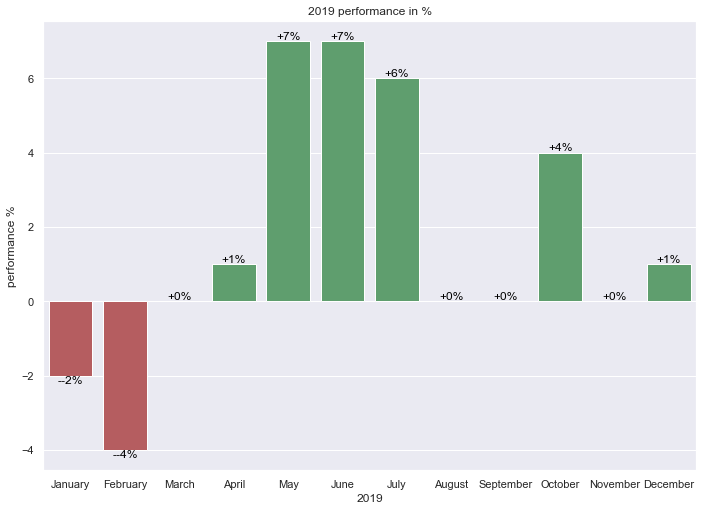

----- 2020 Cumulative Performances: 55.62% -----


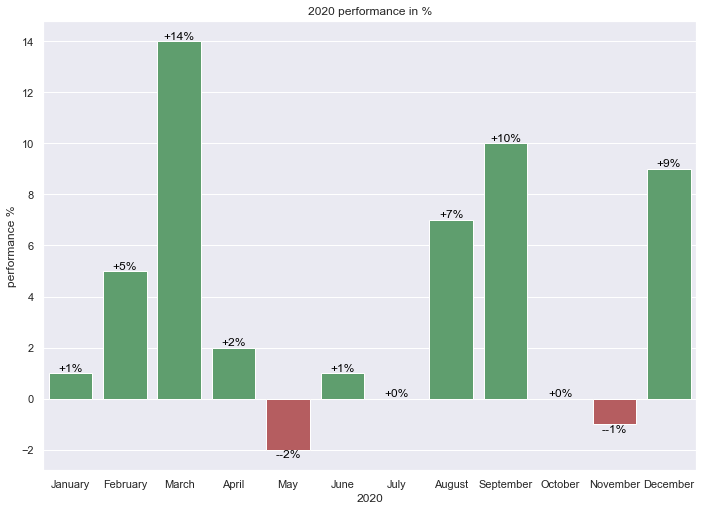

----- 2021 Cumulative Performances: 142.07% -----


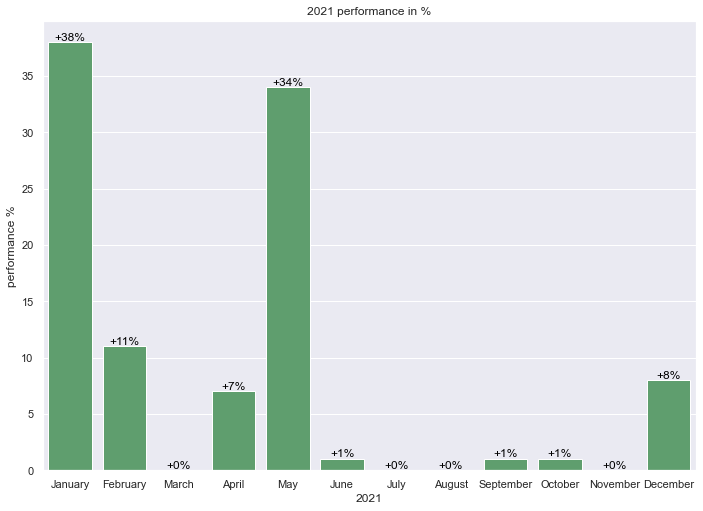

----- 2022 Cumulative Performances: 31.75% -----


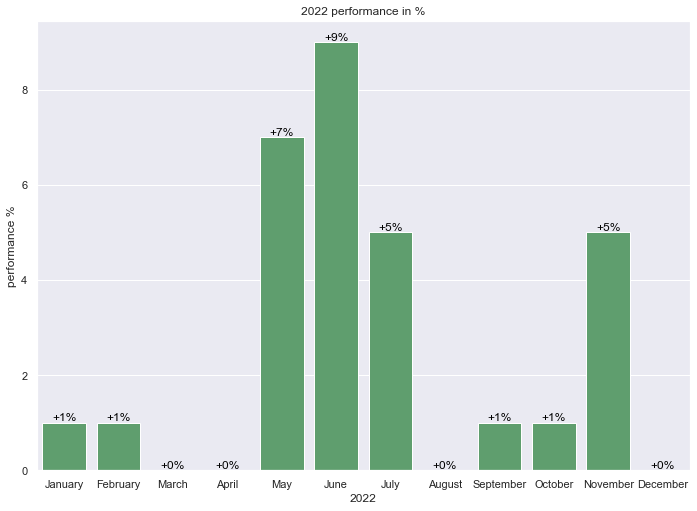

----- 2023 Cumulative Performances: 2.3% -----


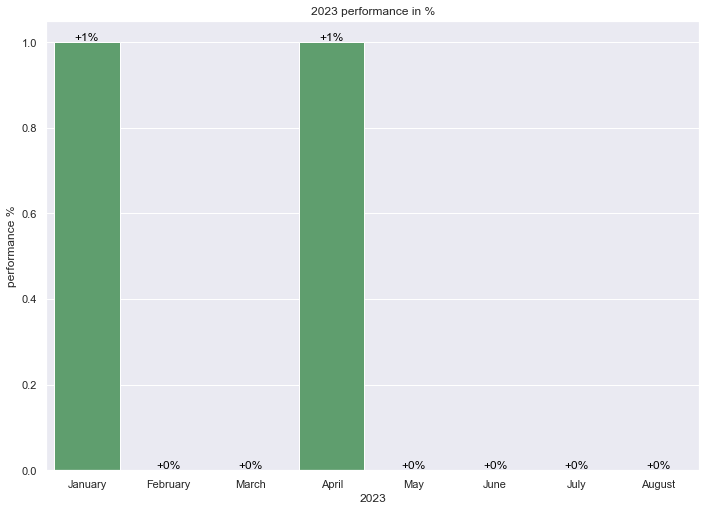

In [5]:
plot_bar_by_month(df_days)

In [6]:
# pair_list = ["BTC/USDT", "ETH/USDT", 'ADA/USDT', 'XRP/USDT', 'BNB/USDT']
# # pair_list = COIN_LIST["spot_binance"]["implose_nico_binance"]
# # tf_list = ["15m"]
# tf_list = ["1h", "2h", "4h"]
# # tf_list = ["1h"]

# result = []
# exchange = ExchangeDataManager(exchange_name="binance", path_download="../database/exchanges")

# for pair in pair_list:
#     clear_output(wait=True)
#     print(pair, str(pair_list.index(pair))+"/"+str(len(pair_list)))
#     for tf in tf_list:
#         try:
#             df = exchange.load_data(coin=pair, interval=tf)           
#             # df_1d = exchange.load_data(coin=pair, interval="1d")          
#             strat = BolAnomaly(
#                 df = df.loc[:],
#                 type=["long","short"],
#                 param0=30,
#                 param1=2.75,
#                 param2=0.02,
#             )
#             strat.populate_indicators()
#             strat.populate_buy_sell()
#             bt_result = strat.run_backtest(initial_wallet=1000)
#             result.append({
#                 "pair": pair,
#                 "tf": tf,
#                 "sharpe_ratio": round(bt_result['sharpe_ratio'],2),
#                 "max_drawdown": round(bt_result['max_drawdown'],2),
#                 "wallet": round(bt_result['wallet'],2),
#                 "trades": len(bt_result["trades"]),
#                 "win_rate": bt_result["win_rate"],
#             }) 
#         except Exception as e:
#             print("Error on pair:", pair, "tf:", tf, "sma0_window:", i)
#             pass
            
# df_result = pd.DataFrame(result).sort_values(by="tf")      
# clear_output(wait=True)
# print(df_result.groupby(by="tf")['sharpe_ratio'].mean())
# print("/////")
# print(df_result.groupby(by="tf")['max_drawdown'].mean())  

# df_result.sort_values(by="sharpe_ratio", ascending=False)